In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [7]:
data = pd.read_csv('data/datatest.txt')
data2 = pd.read_csv('data/datatraining.txt')
data3 = pd.read_csv('data/datatest2.txt')

In [8]:
print(data.iloc[0].date, data.iloc[-1].date)
print(data2.iloc[0].date, data2.iloc[-1].date)
print(data3.iloc[0].date, data3.iloc[-1].date)

2015-02-02 14:19:00 2015-02-04 10:43:00
2015-02-04 17:51:00 2015-02-10 09:33:00
2015-02-11 14:48:00 2015-02-18 09:19:00


In [9]:
data_all = pd.concat([data, data2, data3])

# trasformo in datetime l'elemento 'date'
data_all['date'] = pd.to_datetime((data_all['date']))

# creo delle colonne utili, inizializzandole tutte e zero
data_all['Notte'] = 0.
data_all['Mattina'] = 0.
data_all['Mezzogiorno'] = 0.
data_all['Pomeriggio'] = 0.
data_all['Sera'] = 0.

# assegno i valori alle colonne create sopra
data_all.loc[(data_all['date'].dt.hour < 8) | (data_all['date'].dt.hour > 21), 'Notte'] = 1.
data_all.loc[(data_all['date'].dt.hour <= 12) & (data_all['date'].dt.hour >= 8), 'Mattina'] = 1.
data_all.loc[(data_all['date'].dt.hour > 12) & (data_all['date'].dt.hour <= 15), 'Mezzogiorno'] = 1.
data_all.loc[(data_all['date'].dt.hour > 15) & (data_all['date'].dt.hour <= 18), 'Pomeriggio'] = 1.
data_all.loc[(data_all['date'].dt.hour > 18) & (data_all['date'].dt.hour <= 21), 'Sera'] = 1.

# elimino eventuali duplicati
data_all.drop_duplicates(inplace=True)

# rinomino Occupancy ad Occupato
data_all['Occupato'] = data_all['Occupancy']
del data_all['Occupancy']

# setto 'date' come inide
data_all.set_index('date', inplace=True)

data_all.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Notte,Mattina,Mezzogiorno,Pomeriggio,Sera,Occupato
date,,,,,,,,,,,
2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,0.0,0.0,1.0,0.0,0.0,1
2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,0.0,0.0,1.0,0.0,0.0,1
2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,0.0,0.0,1.0,0.0,0.0,1
2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,0.0,0.0,1.0,0.0,0.0,1
2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,0.0,0.0,1.0,0.0,0.0,1


In [10]:
print(type(data_all))

# creo un oggeto np array associato al dataset
dataset = data_all.values

print(type(dataset))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [11]:
# Divido train e plit test

split_point = int(len(dataset) * 0.95)

x_train = dataset[:split_point,:-1]
y_train = dataset[:split_point,-1]

x_test = dataset[split_point:,:-1]
y_test = dataset[split_point:,-1]

In [12]:
# Normalizzo i dati

scaler = StandardScaler()
scaler.fit(x_train)

x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)

get_time_series(...) si occupa di trasformare il dataset originale in una __serie temporale__ che potrà poi essere data in pasto alla nostra rete ricorrente

In [13]:
def get_time_series(features, labels, steps_back):
    
    assert len(features) == len(labels)
    assert steps_back > 0
    
    ts_features = []
    ts_labels = []
    
    
    """ 
    supponiamo che 
    - steps_back = 3
    - len(features) = 100
    
    avremo i che va da 3 a 100, da cui
    
    i = 3 (prima)
    ts_features.append( features[0 : 3] ) <- da 0 a 2 compresi
    ts_labels.append(labels[2]) <- label elemento 2
  
    --
  
    i = 4
    ts_features.append( features[1 : 4] ) <- da 0 a 3 compresi
    ts_labels.append(labels[3]) <- label elemento 3
    
    [...]

    i = 99  (ultima)
    ts_features.append( features[96 : 99] ) <- da 96 a 98 compresi
    ts_labels.append(labels[98]) <- label elemento 98

    in pratica ts_features è una serie temporale di 97 elementi, ognuno dei quali
    contiene 3 sequenze diverse e, per ognuna di queste segnenze, contiene le varie features
    """
    for i in range(steps_back, len(features)):
        ts_features.append(features[i - steps_back:i])
        ts_labels.append(labels[i - 1])
    
    return np.asarray(ts_features), np.asarray(ts_labels)

steps_back = 60

#Trasformo i dataset di train e i dataset di test in serie temporali
x_train_ts, y_train_ts = get_time_series(x_train_std, y_train, steps_back)
x_test_ts, y_test_ts = get_time_series(x_test_std, y_test, steps_back)

Vari controlli che sia tutto ok

In [14]:
# Verico che la singola serie temporale abbia gli stessi valore
# dei valori contenuti nel rispettivo elemento del dataset originale
assert np.all(x_train_ts[0][0] == x_train_std[0])

# Verifico che l'etichetta della prima serie temporale sia corretta
# (guardo per la prima)
assert y_train_ts[0] == y_train[steps_back]

# Stessa identica cosa su un elemento a caso (42)
assert np.all(x_train_ts[42][0] == x_train_std[42])
assert y_train_ts[42] == y_train[42 + steps_back]

# Rifaccio gli stessi controlli di cui sora, anche per la serie di test
assert np.all(x_test_ts[0][0] == x_test_std[0])
assert y_test_ts[0] == y_test[steps_back]

assert np.all(x_test_ts[42][0] == x_test_std[42])
assert y_test_ts[42] == y_test[42 + steps_back]

Utilizziamo una rete di default di Keras (SimpleRNN)

In [15]:
print(x_train_ts.shape)
print(x_train_ts.shape[1:])

(19472, 60, 10)
(60, 10)


Creo la rete in maniera funzionale, utilizzando la SimpleRNN 

In [16]:
# Definisco l'on input
# con x_train_ts.shape[1:] escludo la prima dimensione perché mi 
# va a rappresentare il numero di esempi del dataset (19472), ma noi
# vogliamo solamente la shape  (60,10)
input = tf.keras.layers.Input(shape=x_train_ts.shape[1:])

# Definisco la RNN associata all'input
rnn = tf.keras.layers.SimpleRNN(units=4, dropout=0.5)(input)

# Definisco l'output
output = tf.keras.layers.Dense(1, activation='sigmoid')(rnn)

# creo il modello
model = tf.keras.models.Model(
    inputs=input,
    outputs=output,
)

# 'compilo' il modello
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=tf.keras.metrics.BinaryAccuracy()
)

model.summary()

'''
calcolo dei parametri:

W(input) + W'(ricorrente) + b

W(input)      = n° features x n° celle
W(ricorrente) = n° celle x n° celle
b             = n° celle x 1

nel nostro caso:
W(input)      = 10 x 4
W(ricorrente) = 4 x 4
b             = 4
-----------------------
Totale        = 40 + 16 + 4 = 60
'''

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 10)]          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 4)                 60        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


"\ncalcolo dei parametri:\n\nW(input) + W'(ricorrente) + b\n\nW(input)      = n° features x n° celle\nW(ricorrente) = n° celle x n° celle\nb             = n° celle x 1\n\nnel nostro caso:\nW(input)      = 10 x 4\nW(ricorrente) = 4 x 4\nb             = 4\n-----------------------\nTotale        = 40 + 16 + 4 = 60\n"

In [17]:
history = model.fit(
    x_train_ts,
    y_train_ts,
    batch_size=256,
    epochs=10,
    validation_data=(
        x_test_ts,
        y_test_ts
    ),
    verbose=2
)

Epoch 1/10
77/77 - 6s - loss: 0.1423 - binary_accuracy: 0.8223 - val_loss: 0.2778 - val_binary_accuracy: 0.1467 - 6s/epoch - 81ms/step
Epoch 2/10
77/77 - 1s - loss: 0.0688 - binary_accuracy: 0.9261 - val_loss: 0.2476 - val_binary_accuracy: 0.2159 - 982ms/epoch - 13ms/step
Epoch 3/10
77/77 - 1s - loss: 0.0409 - binary_accuracy: 0.9623 - val_loss: 0.2666 - val_binary_accuracy: 0.1880 - 940ms/epoch - 12ms/step
Epoch 4/10
77/77 - 1s - loss: 0.0274 - binary_accuracy: 0.9727 - val_loss: 0.0439 - val_binary_accuracy: 0.9411 - 950ms/epoch - 12ms/step
Epoch 5/10
77/77 - 1s - loss: 0.0217 - binary_accuracy: 0.9771 - val_loss: 0.0414 - val_binary_accuracy: 0.9494 - 973ms/epoch - 13ms/step
Epoch 6/10
77/77 - 1s - loss: 0.0189 - binary_accuracy: 0.9791 - val_loss: 0.0148 - val_binary_accuracy: 0.9948 - 967ms/epoch - 13ms/step
Epoch 7/10
77/77 - 1s - loss: 0.0180 - binary_accuracy: 0.9797 - val_loss: 0.0116 - val_binary_accuracy: 0.9948 - 939ms/epoch - 12ms/step
Epoch 8/10
77/77 - 1s - loss: 0.0175 

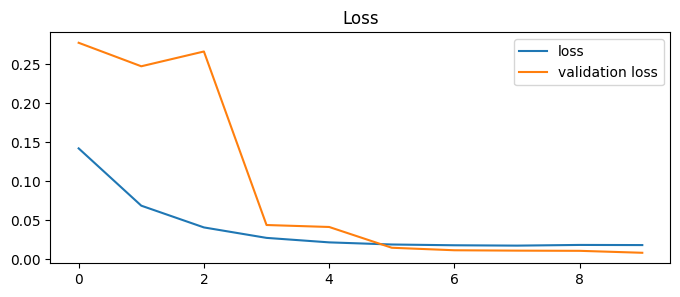

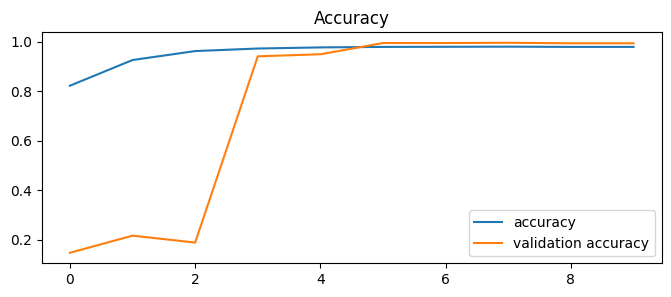

In [18]:
plt.figure(figsize=(8,3))
plt.title('Loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,3))
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [25]:
print( f" Prediction: {model.predict(x_test_ts[42:43])} \n Real: {y_test_ts[42]}" )

1/1 [==============================] - 0s 47ms/step
 Prediction: [[0.96179956]] 
 Real: 1.0


In [26]:
print( f" Prediction: {model.predict(x_test_ts[114:115])} \n Real: {y_test_ts[114]}" )

1/1 [==============================] - 0s 32ms/step
 Prediction: [[0.029289]] 
 Real: 0.0


In [27]:
preds = model.predict(x_test_ts)
preds = preds[:, 0]
preds[preds > 0.5] = 1
preds[preds < 1] = 0

print(accuracy_score(y_test_ts, preds))

31/31 [==============================] - 0s 3ms/step
0.993801652892562
